# Predicting Cirrhosis

## Imports and Custom Functions

In [35]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.inspection import permutation_importance

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [41]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [46]:
# Categorical V Target EDA Function
def plot_categorical_vs_target(df, x, y,figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x]) 
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  
    # Barplot 
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)
  
  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, 
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



In [49]:
# Numeric v Target EDA Function
def plot_numeric_vs_target(df, x, y, figsize=(6,4)):
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax



## Load and Clean the Data

In [3]:
# Load in Data
df = pd.read_csv('Data/cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [5]:
df.isna().sum().sum()

1033

In [6]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

106 patients dropped off before follow-up. They represent most of the missing values. So, I am dropping those rows.

In [7]:
# Drop the rows with missing values
df_new = df.dropna()

In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 311
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             276 non-null    int64  
 1   N_Days         276 non-null    int64  
 2   Status         276 non-null    object 
 3   Drug           276 non-null    object 
 4   Age            276 non-null    int64  
 5   Sex            276 non-null    object 
 6   Ascites        276 non-null    object 
 7   Hepatomegaly   276 non-null    object 
 8   Spiders        276 non-null    object 
 9   Edema          276 non-null    object 
 10  Bilirubin      276 non-null    float64
 11  Cholesterol    276 non-null    float64
 12  Albumin        276 non-null    float64
 13  Copper         276 non-null    float64
 14  Alk_Phos       276 non-null    float64
 15  SGOT           276 non-null    float64
 16  Tryglicerides  276 non-null    float64
 17  Platelets      276 non-null    float64
 18  Prothrombi

In [9]:
df_new.isna().sum().sum()

0

## Exploratory Visualizations

In [10]:
corr = df_new.corr(numeric_only = True)

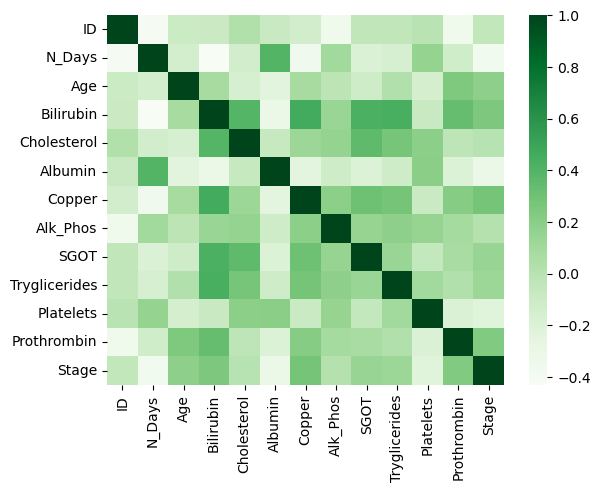

In [11]:
#Create Heatmap to show correlation between numeric features
ax = sns.heatmap(corr, cmap = "Greens")

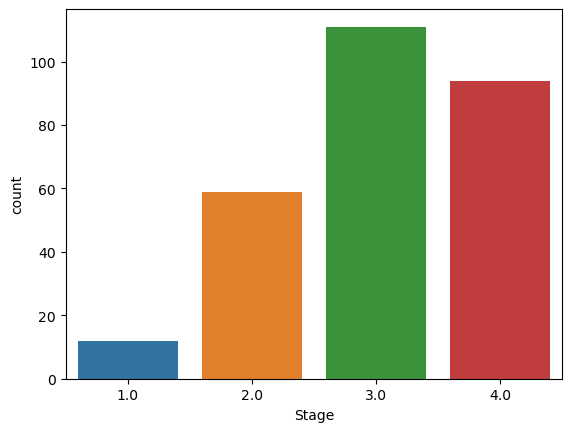

In [12]:
# Create Barplot to show the number of patients in each stage of cirrhosis
ax = sns.countplot(data=df_new, x = "Stage")

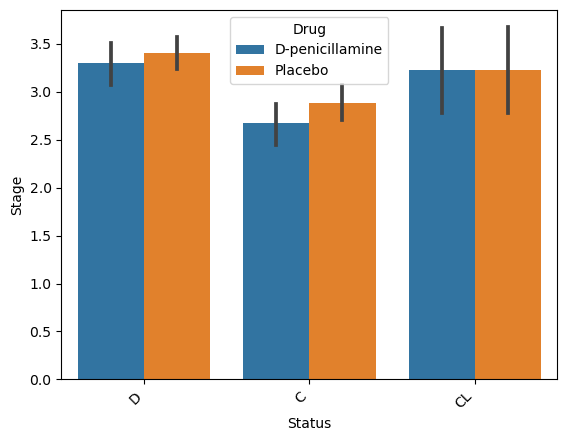

In [13]:
# Create a Grouped Bar Plot of stage and status of patient and whether they were on the drug or a placebo
ax = sns.barplot(data=df_new, x="Status", y="Stage", hue="Drug")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

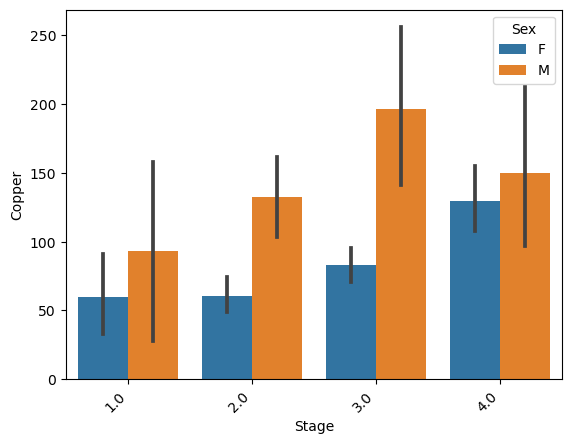

In [14]:
# Create a Grouped Bar Plot of stage, copper levels, and sex
ax = sns.barplot(data=df_new, x="Stage", y="Copper", hue="Sex")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

## Preprocess Data

In [15]:
# Define target
target_col = 'Status'

# Make list of columns to drop. In this case just the id column for now
df_new = df_new.drop(columns = "ID")

# Define X and y
y = df_new[target_col]
X = df_new.drop(columns=[target_col])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



### Create Pipeline

In [22]:
#Create categorical pipeline: Create list, OneHotEncoder, and tuple

#Variable of categorical columns
cat_cols = X_train.select_dtypes('object').columns

#Transformers
ohe = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

#Pipeline
cat_pipeline = make_pipeline(ohe)

#Tuple
ohe_tuple = ('categorical', cat_pipeline, cat_cols)

In [23]:
#Create numerical pipeline: Create list, StandardSclaer and tuple

#Create numerical columns variable
num_cols = X_train.select_dtypes('number').columns

#Transformers
scaler = StandardScaler()

#Pipeline
num_pipeline = make_pipeline(scaler)

#Tuple
num_tuple = ('numeric', num_pipeline, num_cols)

In [24]:
#Build preprocessor with ColumnTransformer
preprocessor = ColumnTransformer([  ohe_tuple,
                                    num_tuple],
                                    verbose_feature_names_out=False)

preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))],
                  verbose_feature_names_out=False)

## Run Model and Evaluate

### Random Forest

In [25]:
#Instantiate Decision Tree Classifier

random_forest = RandomForestClassifier(random_state=42)

In [27]:
#Build DT Pipeline
rf_pipe = make_pipeline(preprocessor, random_forest)

In [28]:
#Fit on the training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       108
          CL       1.00      1.00      1.00        18
           D       1.00      1.00      1.00        81

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207



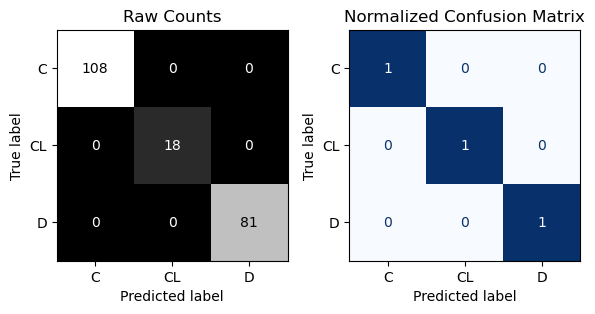


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.81      0.90      0.85        39
           D       0.85      0.73      0.79        30

    accuracy                           0.83        69
   macro avg       0.83      0.82      0.82        69
weighted avg       0.83      0.83      0.82        69



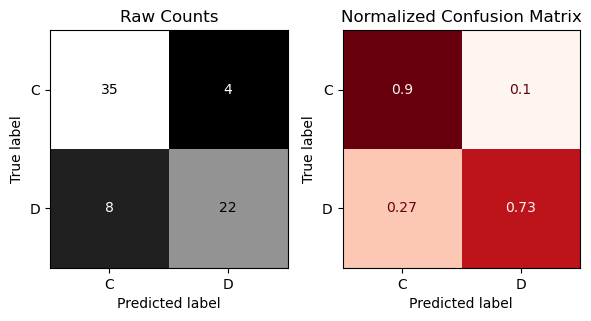

In [29]:
## Evaluate Model
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

### KNN

In [31]:
#Instantiate Decision Tree Classifier

KNN_classifier = KNeighborsClassifier()

In [32]:
#Build DT Pipeline
KNN_pipe = make_pipeline(preprocessor, KNN_classifier)

In [33]:
#Fit on the training data
KNN_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.71      0.90      0.79       108
          CL       0.75      0.17      0.27        18
           D       0.79      0.64      0.71        81

    accuracy                           0.73       207
   macro avg       0.75      0.57      0.59       207
weighted avg       0.74      0.73      0.71       207



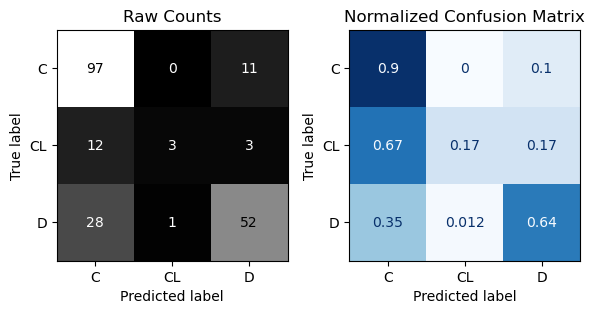


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.82      0.95      0.88        39
          CL       0.00      0.00      0.00         0
           D       0.90      0.63      0.75        30

    accuracy                           0.81        69
   macro avg       0.58      0.53      0.54        69
weighted avg       0.86      0.81      0.82        69



C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


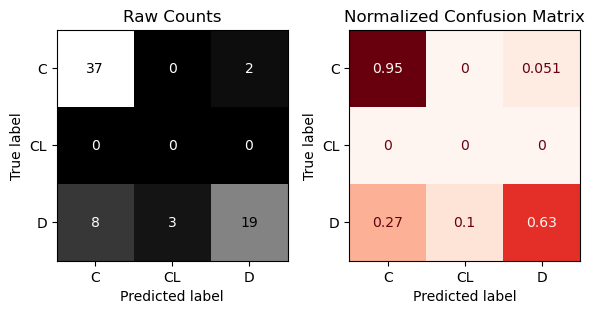

C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
## Evaluate Model
evaluate_classification(KNN_pipe, X_train, y_train, X_test, y_test)

To further refine the model, I would work with the random forest model moving forward.

## Extract Top 10 Features

In [38]:
r = permutation_importance(rf_pipe, X_test, y_test, n_repeats =5, random_state = 42)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [39]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances



N_Days           0.028986
Bilirubin        0.023188
Prothrombin      0.014493
SGOT             0.008696
Alk_Phos         0.005797
Spiders          0.005797
Copper           0.005797
Drug             0.000000
Tryglicerides    0.000000
Stage            0.000000
Edema            0.000000
Ascites          0.000000
Hepatomegaly    -0.002899
Platelets       -0.002899
Sex             -0.005797
Albumin         -0.011594
Age             -0.011594
Cholesterol     -0.020290
Name: permutation importance, dtype: float64

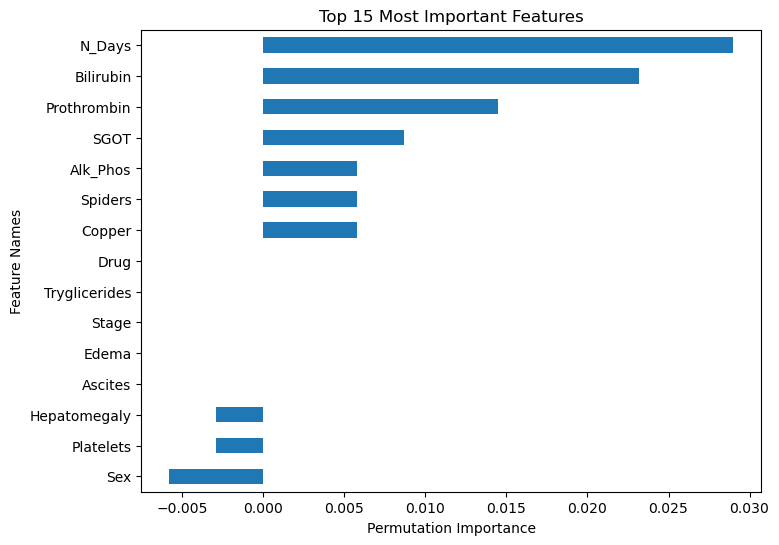

In [42]:
ax = plot_importance(permutation_importances,top_n=15)
ax.set(xlabel='Permutation Importance');


Do these features make sense based on the business case? I would have to refer to the SME about bilirubin. The number of days before an event occurs or check-in could have a strong effect on the status of the patient, as cirrhosis is a progressive disease. I would need to look into why Drug and Stage measures as having zero effect, as that is surprising. 
As knowing whether or not the drug was effective is important, I am going to visualize the relationship between Drug (whether or not D-penicillamine or a placebo were given) and N-Days, and the status of the patient.

## Explanatory Visualizations

The visual below shows the relationship between N_Days, the number of days between registration and a major event such as death, transplantation, or study end, and the patient's status.

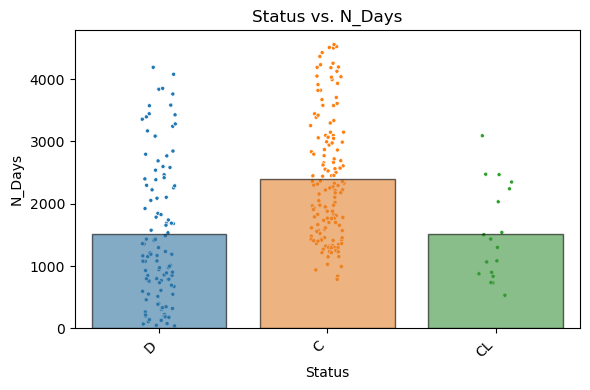

In [61]:
fig, ax = plot_categorical_vs_target(df_new, x = 'Status', y = 'N_Days');

This visual shows that the majority of patients made it to the end of the study at around 2500 days but that a nearly equal amount either died or received a liver transplant in about 1500 days. From an earlier exploratory analysis, it appears that the patients who made it to the end generally were in a lesser stage of cirrhosis. Those who died and received transplants were at more similar stages of the disease.

This visual shows the relationship between whether or not D-penicillamine or a placebo was given and the status of the patient.

<Axes: xlabel='Status', ylabel='Count'>

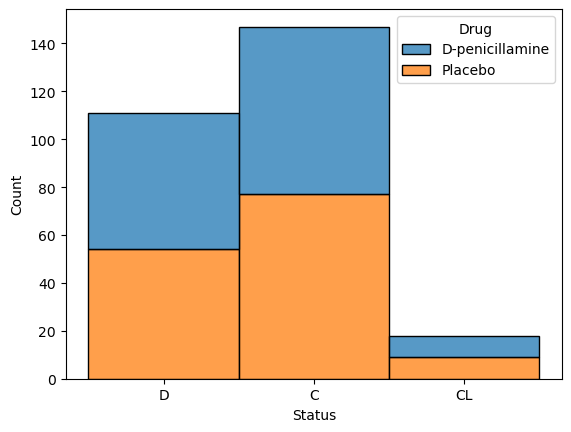

In [57]:
# https://datascience.stackexchange.com/questions/89692/plot-two-categorical-variables

sns.histplot(binwidth=0.5, data=df_new, x="Status", hue="Drug", stat="count", multiple="stack")

There really does not appear to be a correlation between the outcome of a patient and whether or not they were taking D-penicillamine or a placebo.